Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 567 images belonging to 2 classes.
Found 143 images belonging to 2 classes.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/40
18/18 [==============================] - 20s 683ms/step - loss: 0.7449 - accuracy: 0.5503 - val_loss: 0.7323 - val_accuracy: 0.4056
Epoch 2/40
18/18 [==============================] - 13s 726ms/step - loss: 0.7259 - accuracy: 0.5379 - val_loss: 0.7139 - val_accuracy: 0.4056
Epoch 3/40
18/18 [==============================] - 10s 565ms/step - loss: 0.7194 - accuracy: 0.5397 - val_loss: 0.7088 - val_accuracy: 0.4056
Epoch 4/40
18/18 [==============================] - 12s 626ms/step - loss: 0.7274 - accuracy: 0.5714 - val_loss: 0.6926 - val_accuracy: 0.5105
Epoch 5/40
18/18 [==============================] - 12s 656ms/step - loss: 0.6895 - accuracy: 0.6014 - val_loss: 0.6869 - val_accuracy: 0.6224
Epoch 6/40
18/18 [==============================] - 13s 695ms/step - loss: 0.6851 - accuracy: 0.5750 - val_loss: 0.6865 - val_accuracy: 0.6224
Epoch 7/40
18/18 [==============================] - 11s 635ms/step - loss: 0.6814 - accuracy: 0.5661 - val_loss: 0.6736 - val_accuracy: 0.6224

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/MyDrive/model.h5
4/4 [==============================] - 1s 144ms/step
Inconsistent sample size: Predicted 128, True 143
Mean Absolute Error: 0.3828
Mean Squared Error: 0.3828
Recall: 0.0698
Precision: 0.2500
F1 Score: 0.1091
History plot saved to /content/drive/MyDrive/history_plot.png


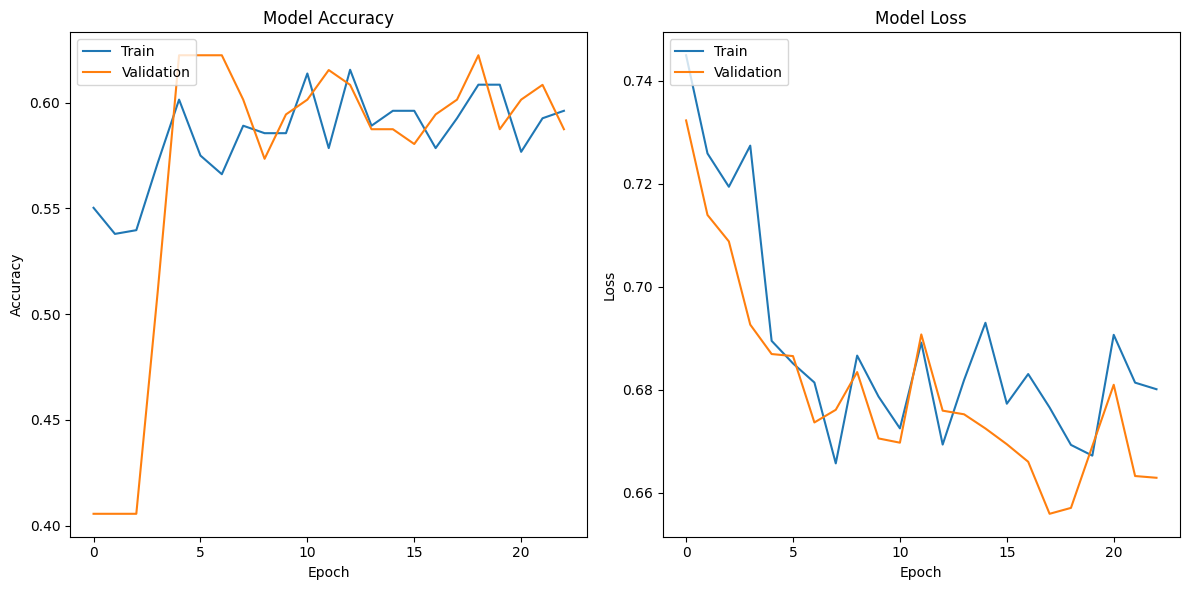

In [7]:
# Install necessary packages
!pip install numpy tensorflow matplotlib scikit-learn tqdm

# Import libraries
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from tqdm.keras import TqdmCallback
from google.colab import drive
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths to the dataset directory
def get_data_paths():
    base_path = '/content/drive/MyDrive/Dataset'
    return base_path

# Split data into training and validation sets
def split_data(base_path, split_ratio=0.2):
    train_dir = os.path.join(base_path, 'train')
    val_dir = os.path.join(base_path, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    categories = ['Anemic', 'Non-anemic']

    for category in categories:
        category_path = os.path.join(base_path, category)
        train_category_dir = os.path.join(train_dir, category)
        val_category_dir = os.path.join(val_dir, category)
        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(val_category_dir, exist_ok=True)

        all_files = os.listdir(category_path)
        all_files = [os.path.join(category_path, file) for file in all_files]

        train_files, val_files = train_test_split(all_files, test_size=split_ratio, random_state=42)

        for file in train_files:
            shutil.copy(file, train_category_dir)
        for file in val_files:
            shutil.copy(file, val_category_dir)

# Load and preprocess the data
def create_data_generators(train_dir, val_dir, img_height=224, img_width=224, batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_generator, val_generator

# Define the ResNet50 model
def create_model(num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout for regularization
    predictions = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze some of the top layers
    for layer in base_model.layers[:143]:  # Unfreeze top layers
        layer.trainable = False
    for layer in base_model.layers[143:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjust learning rate
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Training the model with progress bar
def train_model(model, train_generator, val_generator, epochs=40, model_save_path='/content/drive/MyDrive/model.h5'):
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[TqdmCallback(verbose=1), tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]  # Add EarlyStopping
    )

    # Save the model
    model.save(model_save_path)
    print(f'Model saved to {model_save_path}')

    return history

# Load a saved model
def load_model(model_path='/content/drive/MyDrive/model.h5'):
    model = tf.keras.models.load_model(model_path)
    print(f'Model loaded from {model_path}')
    return model

# Evaluate the model
def evaluate_model(model, val_generator):
    val_steps = val_generator.samples // val_generator.batch_size
    val_generator.reset()
    predictions = model.predict(val_generator, steps=val_steps, verbose=1)
    y_pred = (predictions > 0.5).astype(int)
    y_true = val_generator.classes

    if len(y_pred) != len(y_true):
        print(f"Inconsistent sample size: Predicted {len(y_pred)}, True {len(y_true)}")
        min_len = min(len(y_pred), len(y_true))
        y_pred = y_pred[:min_len]
        y_true = y_true[:min_len]

    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Plot training history and save to file
def plot_history(history, plot_save_path='/content/drive/MyDrive/history_plot.png'):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig(plot_save_path)  # Save the plot
    print(f'History plot saved to {plot_save_path}')
    plt.show()

# Main function
def main():
    base_path = get_data_paths()
    split_data(base_path, split_ratio=0.2)  # Split data into train and validation sets

    train_dir = os.path.join(base_path, 'train')
    val_dir = os.path.join(base_path, 'val')

    train_generator, val_generator = create_data_generators(train_dir, val_dir)

    num_classes = 1  # For binary classification

    model = create_model(num_classes)
    history = train_model(model, train_generator, val_generator)
    evaluate_model(model, val_generator)
    plot_history(history)

    # To load the model and continue training or evaluation
    # model = load_model()  # Uncomment this if you need to load a saved model

if __name__ == '__main__':
    main()
